In [40]:
import sys
sys.path.append('Painter/SegGPT/SegGPT_inference')

In [41]:
sys.path.append("/home/eric/srcs/FewShotSeg_Lab/FewShotVision_Lab/OEM-Few-Shot-Learnable-Prompt")
import os
import torch as T
import argparse
import numpy as np
from typing import Dict
from utils import *
import torch.nn.functional as F
import os.path as osp
from data import OEMAdapterDataset, OEMAdapterDatasetV2, OEMAdapterDatasetV3

In [42]:
import sys
sys.path.append('/home/eric/srcs/FewShotSeg_Lab/FewShotVision_Lab/OEM-Few-Shot-Learnable-Prompt/Painter/SegGPT/SegGPT_inference')
from Painter.SegGPT.SegGPT_inference.models_seggpt import seggpt_vit_large_patch16_input896x448
from model import AdapterSegGPT
from PIL import Image
from tqdm import tqdm
import torch

In [43]:
ckpt_path = "/home/eric/srcs/FewShotSeg_Lab/FewShotVision_Lab/OEM-Few-Shot-Learnable-Prompt/logs/1731148806/weights/epoch08_temp_eric_fix_plz.pt"

In [90]:
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMANGENET_STD = np.array([0.229, 0.224, 0.225])

COLOR_MAP = np.array([
    (0, 0,  0),
    (255, 255, 255),
])

@torch.no_grad()
def run_one_image(img, tgt, model, device, mask=None):
    x = torch.tensor(img)
    x = torch.einsum('nhwc->nchw', x)

    tgt = torch.tensor(tgt)
    tgt = torch.einsum('nhwc->nchw', tgt)
    
    if mask is None:
        bool_masked_pos = torch.zeros(model.seggpt.patch_embed.num_patches)
        bool_masked_pos[model.seggpt.patch_embed.num_patches//2:] = 1
        bool_masked_pos = bool_masked_pos.unsqueeze(dim=0)
    else:
        bool_masked_pos = torch.tensor(mask).unsqueeze(dim=0)
    valid = torch.ones(tgt.shape[0], tgt.shape[1], tgt.shape[2] * 2, tgt.shape[3])
    seg_type = torch.zeros([valid.shape[0], 1])
    
    feat_ensemble = 0 if len(x) > 1 else -1
    _, y, mask = model(x.float().to(device), tgt.float().to(device), bool_masked_pos.to(device), valid.float().to(device), seg_type.to(device), feat_ensemble)
    y = model.seggpt.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    output = y[0, y.shape[1]//2:, :, :]
    output = torch.clip((output * IMANGENET_STD + IMAGENET_MEAN) * 255, 0, 255)
    
    mask = mask[:, :, None].repeat(1, 1, model.seggpt.patch_size**2 * 3)
    mask = model.seggpt.unpatchify(mask)
    mask = mask.permute(0, 2, 3, 1)
    mask = mask[0, mask.shape[1]//2:, :, :]
    mask = mask.cpu().float()

    return output, mask

In [91]:
import torch as T
import argparse
import json
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

In [92]:
config_path = "/home/eric/srcs/FewShotSeg_Lab/FewShotVision_Lab/OEM-Few-Shot-Learnable-Prompt/configs/adapter_single.json"

def get_args_parser(args=None):
    parser = argparse.ArgumentParser('SegGPT train adapter', add_help=False)
    parser.add_argument('--config', type=str, default=f'{config_path}', required=False)
    parser.add_argument('--port', type=int, help='DDP port', default=12355)
    parser.add_argument('--phase-2', action='store_true', help='phase 2 training, positive negative samples')
    parser.add_argument('--adapter-path', type=str, help='path to adapter checkpoint')
    parser.add_argument('--uid', type=str, help='unique id for the run', default=None)
    parser.add_argument('--lr', type=float, help='learning rate', default=None)
    parser.add_argument('--epoch', type=int, help='epoch', default=None)
    parser.add_argument('--ckpt-interval', type=int, help='checkpoint interval (in epoch)', default=None)
    return parser.parse_args([])

In [93]:
args = get_args_parser([])

In [94]:
args.config

'/home/eric/srcs/FewShotSeg_Lab/FewShotVision_Lab/OEM-Few-Shot-Learnable-Prompt/configs/adapter_single.json'

In [95]:
train_args = json.load(open(args.config, 'r'))
train_args['adapter_path'] = args.adapter_path
train_args['phase_2'] = args.phase_2
if args.uid is not None:
    train_args['uid'] = args.uid
if args.lr is not None:
    train_args['lr'] = args.lr
if args.epoch is not None:
    train_args['epoch'] = args.epoch
if args.ckpt_interval is not None:
    train_args['ckpt_interval'] = args.ckpt_interval

In [50]:
valid_dataset = OEMAdapterDatasetV3(
    root = train_args['train_dataset_dir'],
    mean = train_args['image_mean'],
    std = train_args['image_std'],
    resize = (1024, 1024),
    smallest_crop_size=train_args['smallest_crop_size'], 
    biggest_crop_size=train_args['biggest_crop_size'],
    smallest_stride=train_args['smallest_stride'],
    is_train=False,
    is_phase_2=train_args['phase_2'],
)


Caching images and grouping labels: 100%|██████████| 2/2 [00:00<00:00, 28.54it/s]

filename /home/eric/data/demoset/images/1.png
filename /home/eric/data/demoset/labels/1.png
filename /home/eric/data/demoset/images/2.png
filename /home/eric/data/demoset/labels/2.png
#--- preload
self.images 2


In [51]:
img, label, mask, valid, seg_type, ori_label, color_palette = valid_dataset.__getitem__(0)

In [52]:
def torch_denormalize(img):
    img[0,:]  =  (img[0,:]* 0.229) + 0.485
    img[1,:]  =  (img[1,:]* 0.224) + 0.456
    img[2,:]  =  (img[2,:]* 0.225) + 0.406
    return img   

def torch_display(image,batch,denormal):
    '''
    input shape : batch or not  
    
    torch.Size([batch, channel, 256, 256])
    '''
    img = image.clone() 
    if batch:
        img = img[0,:]
    else:
        pass
    
    #----- denormalizing func
    if denormal:
        # [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
        img = torch_denormalize(img)
    #-----
             
    img = img.permute(1,2,0)
    img = np.asarray(img)   
    
    fig_size= (10,10)
    plt.figure(figsize=fig_size)
    plt.imshow(img)

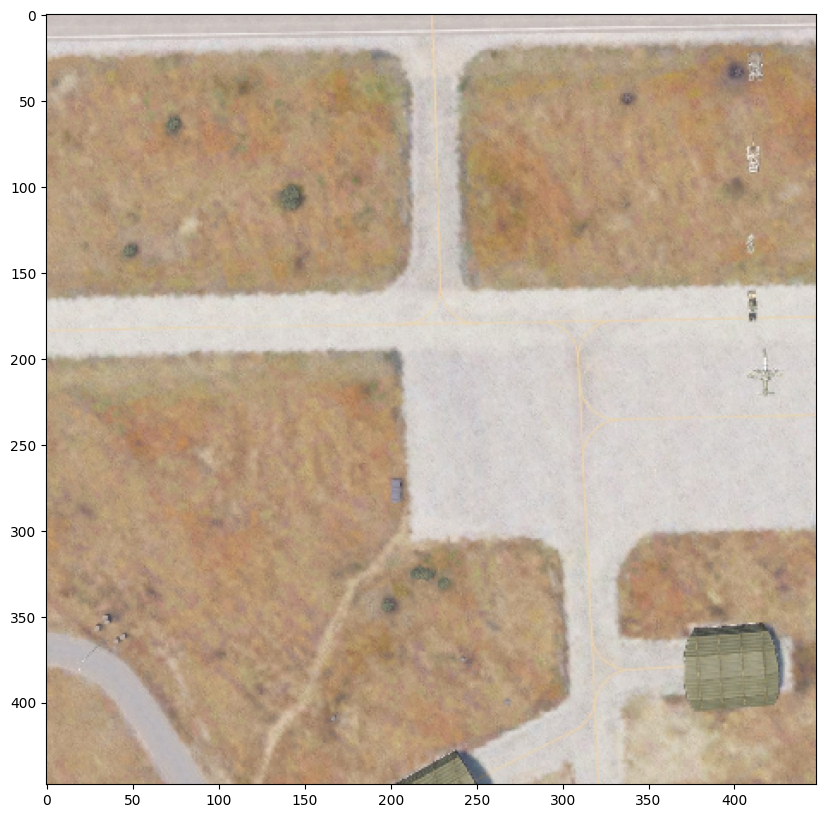

In [53]:
torch_display(img,False,True)

In [54]:
args.ckpt_path = ckpt_path

In [55]:
device = 0 

In [87]:
base_model = seggpt_vit_large_patch16_input896x448()
#ckpt = T.load(args.ckpt_path, map_location='cpu')
#base_model.load_state_dict(ckpt['model_state_dict'],strict=False)
#print('Base checkpoint loaded')
#base_model = base_model.to(device)
#base_model.eval()

In [88]:
args.ckpt_path

'/home/eric/srcs/FewShotSeg_Lab/FewShotVision_Lab/OEM-Few-Shot-Learnable-Prompt/logs/1731148806/weights/epoch08_temp_eric_fix_plz.pt'

In [63]:
novel_model = AdapterSegGPT(base_model)
ckpt = T.load(osp.join(args.ckpt_path), map_location='cpu')

novel_model.load_state_dict(ckpt['model_state_dict'], strict=False)
novel_model.image_tensor.data = ckpt['model_state_dict']['image_tensor']
novel_model.mask_tensor.data = ckpt['model_state_dict']['mask_tensor']

In [69]:
novel_model = novel_model.to(device)
_ = novel_model.eval()

In [73]:
image_path = "/home/eric/data/Military/patch_8.png"

In [74]:
def cmap_to_lbl(cmap: torch.Tensor, color_palette: torch.Tensor):
    B, H, W, C = cmap.shape
    _, N, _ = color_palette.shape
    
    dist_mat = torch.cdist(cmap.reshape(B, H * W, C), color_palette, p=2)
    dist_mat = dist_mat.reshape(B, H, W, N)
    label = torch.argmin(dist_mat, axis=3)

    result = torch.zeros_like(cmap)
    for i in range(B):
        for j in range(N):
            result[i][label[i] == j] = color_palette[i][j]

    return result, label

In [82]:
# image = full_image.crop((row * row_size, col * col_size, (row + 1) * row_size, (col + 1) * col_size))
# input_image = np.array(image)
res, hres = 448, 448
image = Image.open(image_path)

image = np.array(image.resize((res, hres))) / 255.
image = (image - IMAGENET_MEAN) / IMANGENET_STD
image = np.expand_dims(image, axis=0)
tgt = np.zeros_like(image)

device = 0
torch.manual_seed(2)
output, _ = run_one_image(image, tgt, novel_model, device)
output = F.interpolate(
    output[None, ...].permute(0, 3, 1, 2), 
    size=[res, hres],
    mode='nearest',).permute(0, 2, 3, 1)

filename /home/eric/data/Military/patch_8.png


In [89]:
output.shape

torch.Size([1, 448, 448, 3])

In [96]:
out_ = output[0]

In [99]:
output, label = cmap_to_lbl(output, torch.tensor(COLOR_MAP, device=output.device, dtype=output.dtype).unsqueeze(0))
output = output[0].numpy()
label = label[0].numpy()

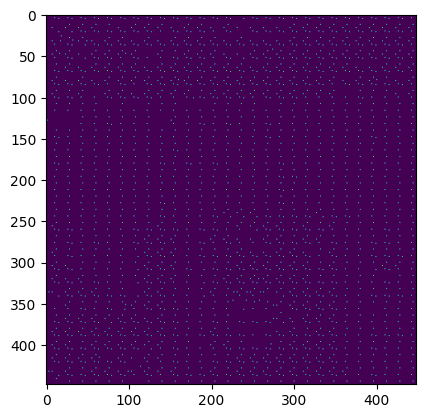

In [101]:
plt.imshow(label)